<a href="https://colab.research.google.com/github/Maheshkonagandla/Cancer-detection/blob/main/Melanoma_SkinCancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/SkinCancerDataset.zip" > /dev/null

unzip:  cannot find or open /content/gdrive/MyDrive/SkinCancerDataset.zip, /content/gdrive/MyDrive/SkinCancerDataset.zip.zip or /content/gdrive/MyDrive/SkinCancerDataset.zip.ZIP.


In [3]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Test")

In [7]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 2239 files belonging to 9 classes.


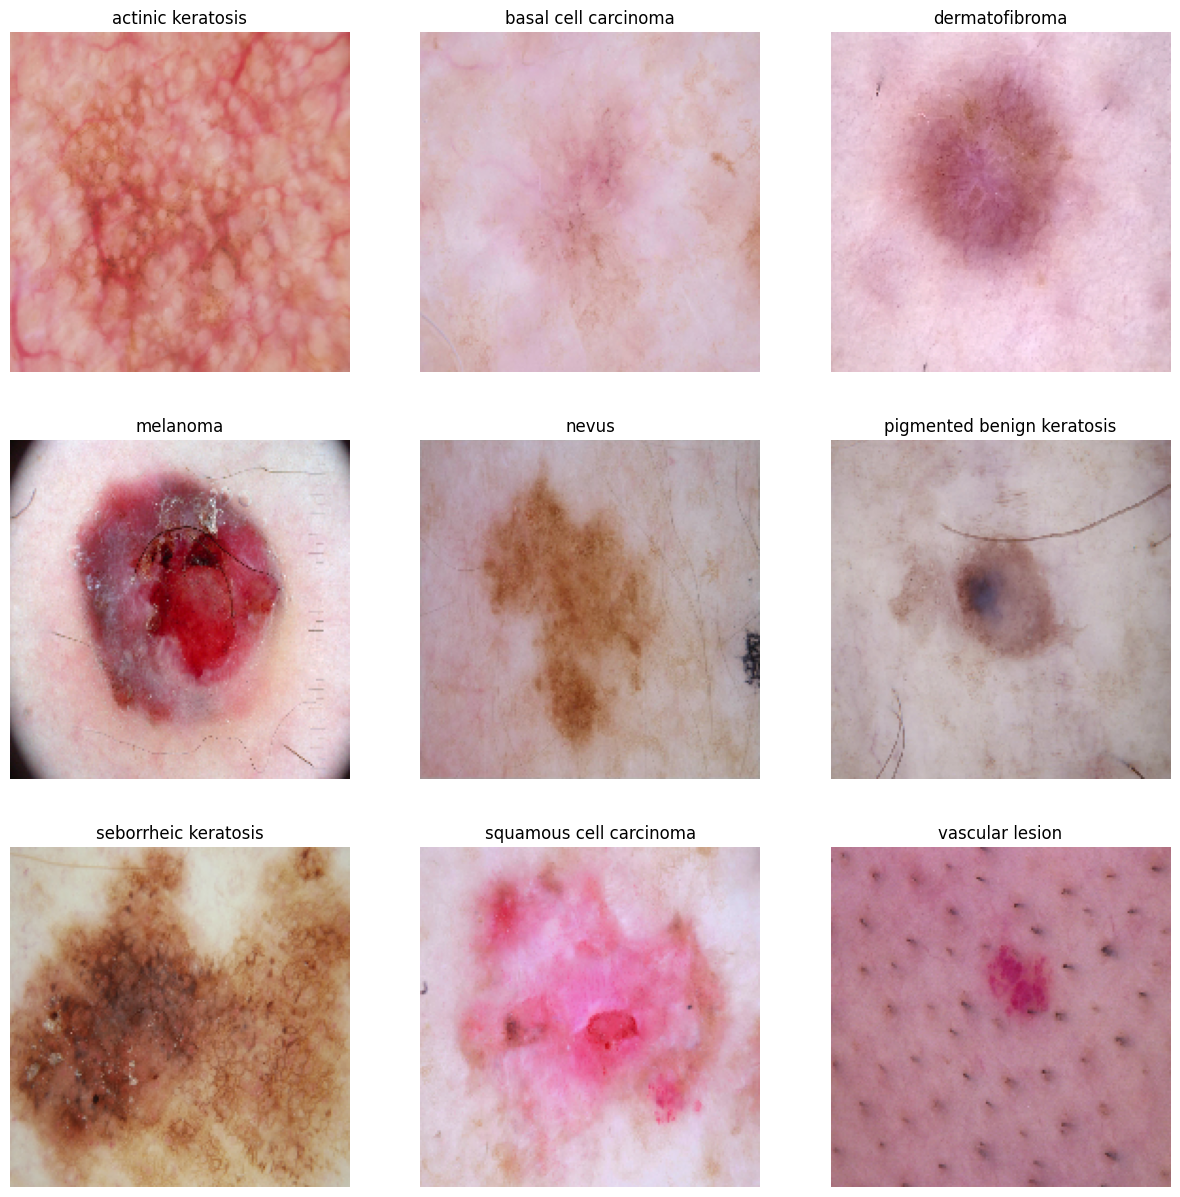

In [8]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [9]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,squamous cell carcinoma,181
1,melanoma,438
2,actinic keratosis,114
3,dermatofibroma,95
4,seborrheic keratosis,77
5,nevus,357
6,vascular lesion,139
7,basal cell carcinoma,376
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

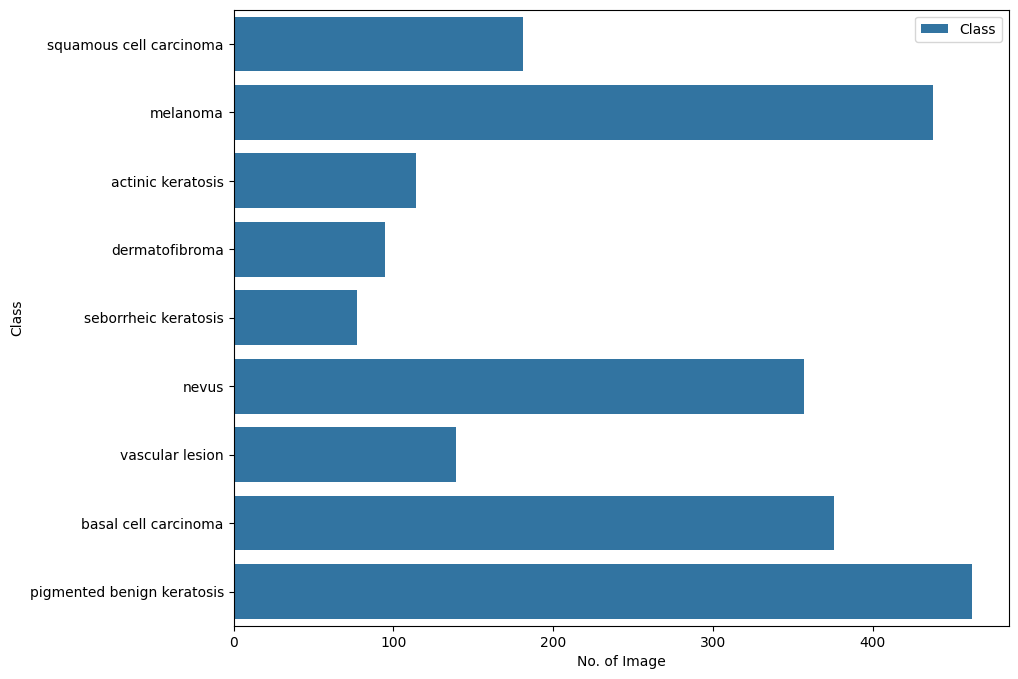

In [10]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [11]:
#install Augmentor
!pip install Augmentor

In [13]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Train/" # Add a trailing slash
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EC68794E810>: 100%|██████████| 500/500 [00:17<00:00, 28.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EC6980F3FD0>: 100%|██████████| 500/500 [00:18<00:00, 27.68 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC687911550>: 100%|██████████| 500/500 [00:17<00:00, 28.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7EC6B8238B10>: 100%|██████████| 500/500 [01:40<00:00,  4.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2530x2122 at 0x7EC6840E4890>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC6983ACC10>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EC68791DC10>: 100%|██████████| 500/500 [00:39<00:00, 12.62 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC69813B1D0>: 100%|██████████| 500/500 [00:18<00:00, 26.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC687925190>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]


In [14]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [15]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [16]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [17]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer - changed to tf.keras.layers.Rescaling
# The 'experimental' module was removed and Rescaling is now directly under tf.keras.layers
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

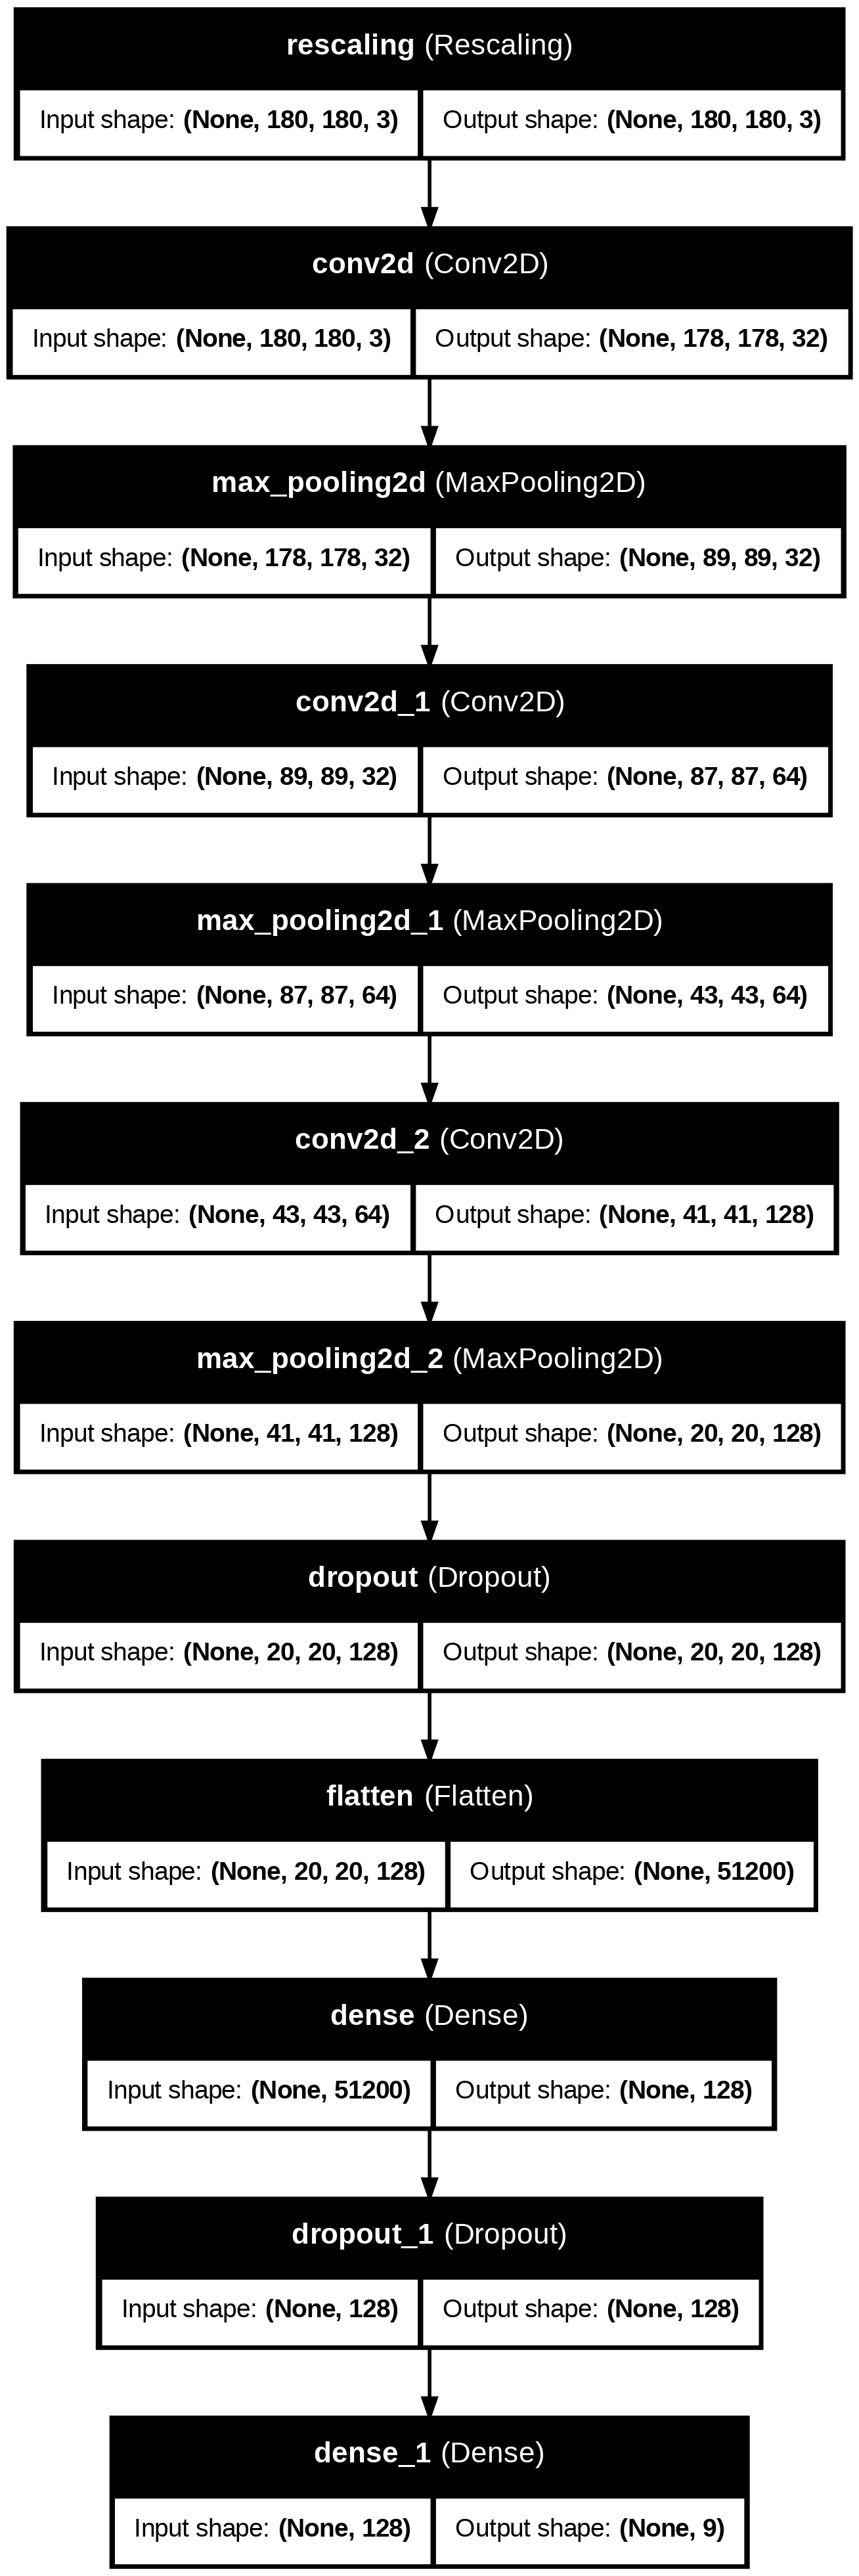

In [20]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [22]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1904 - loss: 2.1676
Epoch 1: val_accuracy improved from -inf to 0.38233, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 110ms/step - accuracy: 0.1913 - loss: 2.1649 - val_accuracy: 0.3823 - val_loss: 1.6068
Epoch 2/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4017 - loss: 1.5525
Epoch 2: val_accuracy improved from 0.38233 to 0.46548, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4019 - loss: 1.5522 - val_accuracy: 0.4655 - val_loss: 1.3644
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4732 - loss: 1.3693
Epoch 3: val_accuracy improved from 0.46548 to 0.56644, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4733 - loss: 1.3691 - val_accuracy: 0.5664 - val_loss: 1.1498
Epoch 4/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5465 - loss: 1.2191
Epoch 4: val_accuracy improved from 0.56644 to 0.56793, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5465 - loss: 1.2191 - val_accuracy: 0.5679 - val_loss: 1.1485
Epoch 5/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5722 - loss: 1.1050
Epoch 5: val_accuracy improved from 0.56793 to 0.61841, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5724 - loss: 1.1048 - val_accuracy: 0.6184 - val_loss: 1.0130
Epoch 6/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6330 - loss: 0.9807
Epoch 6: val_accuracy improved from 0.61841 to 0.66741, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6330 - loss: 0.9806 - val_accuracy: 0.6674 - val_loss: 0.8971
Epoch 7/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6661 - loss: 0.9042
Epoch 7: val_accuracy did not improve from 0.66741
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6660 - loss: 0.9045 - val_accuracy: 0.6459 - val_loss: 0.9130
Epoch 8/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6966 - loss: 0.7995
Epoch 8: val_accuracy improved from 0.66741 to 0.70156, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6967 - loss: 0.7994 - val_accuracy: 0.7016 - val_loss: 0.7924
Epoch 9/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6892 - loss: 0.8169
Epoch 9: val_accuracy improved from 0.70156 to 0.70230, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6893 - loss: 0.8164 - val_accuracy: 0.7023 - val_loss: 0.7651
Epoch 10/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7594 - loss: 0.6541
Epoch 10: val_accuracy improved from 0.70230 to 0.73571, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7594 - loss: 0.6541 - val_accuracy: 0.7357 - val_loss: 0.7394
Epoch 11/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7672 - loss: 0.6191
Epoch 11: val_accuracy improved from 0.73571 to 0.75650, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7672 - loss: 0.6190 - val_accuracy: 0.7565 - val_loss: 0.6888
Epoch 12/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7820 - loss: 0.5778
Epoch 12: val_accuracy improved from 0.75650 to 0.78322, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7820 - loss: 0.5775 - val_accuracy: 0.7832 - val_loss: 0.6262
Epoch 13/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8097 - loss: 0.5113
Epoch 13: val_accuracy improved from 0.78322 to 0.78619, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8096 - loss: 0.5116 - val_accuracy: 0.7862 - val_loss: 0.6279
Epoch 14/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8228 - loss: 0.4766
Epoch 14: val_accuracy improved from 0.78619 to 0.78768, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8226 - loss: 0.4769 - val_accuracy: 0.7877 - val_loss: 0.6295
Epoch 15/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8293 - loss: 0.4491
Epoch 15: val_accuracy improved from 0.78768 to 0.79287, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8293 - loss: 0.4491 - val_accuracy: 0.7929 - val_loss: 0.6600
Epoch 16/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8065 - loss: 0.5154
Epoch 16: val_accuracy improved from 0.79287 to 0.79733, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8067 - loss: 0.5151 - val_accuracy: 0.7973 - val_loss: 0.6038
Epoch 17/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8477 - loss: 0.4039
Epoch 17: val_accuracy improved from 0.79733 to 0.81218, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8477 - loss: 0.4039 - val_accuracy: 0.8122 - val_loss: 0.6124
Epoch 18/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8603 - loss: 0.3763
Epoch 18: val_accuracy did not improve from 0.81218
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8603 - loss: 0.3763 - val_accuracy: 0.7617 - val_loss: 0.7240
Epoch 19/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8488 - loss: 0.3885
Epoch 19: val_accuracy improved from 0.81218 to 0.83370, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8489 - loss: 0.3884 - val_accuracy: 0.8337 - val_loss: 0.5703
Epoch 20/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8809 - loss: 0.3190
Epoch 20: val_accuracy did not improve from 0.83370
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8809 - loss: 0.3192 - val_accuracy: 0.8300 - val_loss: 0.5837


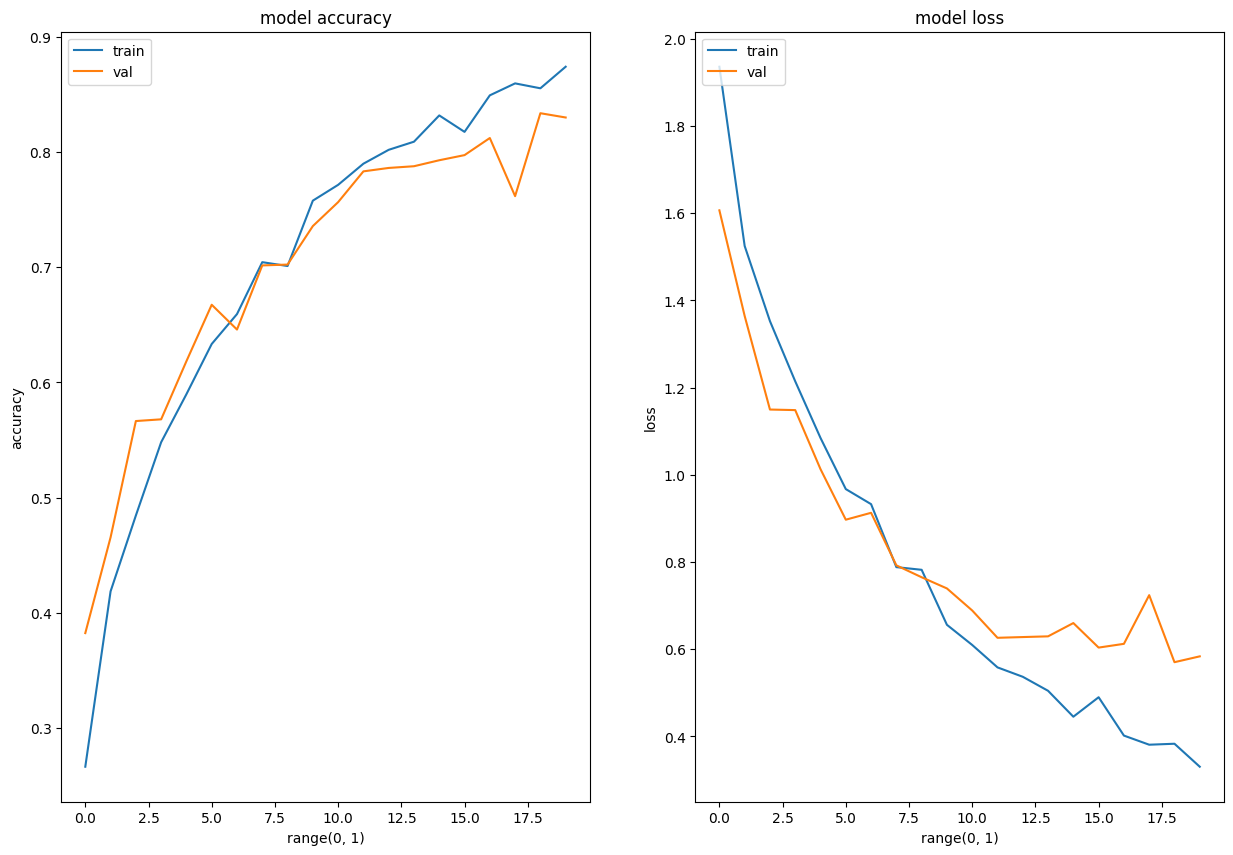

In [23]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class basal cell carcinoma
Predictive Class squamous cell carcinoma


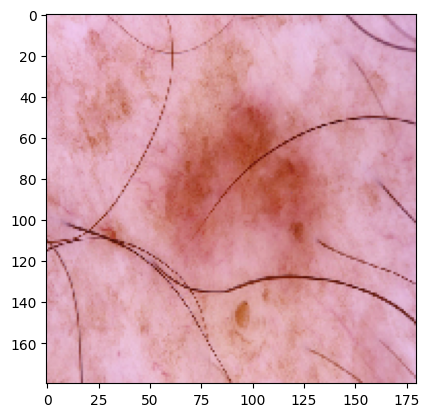

In [30]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
# Get a list of all image files within the 'Test' directory and its subdirectories
Test_image = glob(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/Test', '**', '*.jpg'))
# Load the first image from the list
Test_image = load_img(Test_image[7],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )